In [1]:
import sys
import os
from pathlib import Path
pythonPath = Path(os.getcwd()).resolve().parent.parent / "python"
rmsKitPath = pythonPath / "rmsKit"
sys.path.append(rmsKitPath.as_posix())
from utils import path_with_lowest_loss, sum_ham, stoquastic  # noqa: E402
import numpy as np  # noqa: E402
from lattice import FF  # noqa: E402
import pandas as pd  # noqa: E402
from matplotlib import pyplot as plt  # noqa: E402
import seaborn as sns  # noqa: E402

bd = 2
sps = 3
lt = 1
sps = sps ** lt

def check_valid_seeds(base_path, sps, lt, setting_name, range_seed=range(3000, 4000)):
    valid_seeds = []
    valid_path = []
    for seed in range_seed:
        dir_path = f"{base_path}/s_{sps}_r_2_d_1_seed_{seed}/{setting_name}"
        if os.path.isdir(dir_path):
            valid_seeds.append(seed)
            valid_path.append(dir_path)
    return valid_seeds, valid_path


base_path = rmsKitPath / "array/torch/FF1D_loc_qsmel"
# base_path = "array/torch/FF1D_loc_lt_2"
setting_name = f"1_6qsmel/Adam/lr_0.002_epoch_1000"
h_path = Path(base_path) / "1_6qsmel"
# setting_name = "2_mel_Adam/lr_0.001_epoch_8000"
# base_path = "array/torch/FF1D_lt_2"

valid_seeds, valid_path = check_valid_seeds(
    base_path, sps, lt=lt, setting_name=setting_name, range_seed=range(3000, 4000))

In [2]:
from pathlib import Path

In [39]:
u_path, lowest_val = path_with_lowest_loss(valid_path[7])
lowest_val
h_matrix = -np.load((Path(u_path).parent.parent.parent.parent / "H" / "0.npy").resolve().as_posix())
uq = np.load(u_path + "/0.npy")
u1 = np.load("/Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3000/1_mel/Adam/lr_0.001_epoch_15000/loss_0.1289608/u/0.npy")
Uq = np.kron(uq, uq)
U1 = np.kron(u1,u1)
huq = Uq @ h_matrix @ Uq.T
hu1 = U1 @ h_matrix @ U1.T
L = 6
sps = 3
H = sum_ham(huq, [[i, (i + 1) % L] for i in range(L)], L, sps)
H1 = sum_ham(hu1, [[i, (i + 1) % L] for i in range(L)], L, sps)
E = np.linalg.eigvalsh(stoquastic(H))
E1 = np.linalg.eigvalsh(stoquastic(H1))
print(E[0])

min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3007/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0106921/u
-0.16400089907924542


In [7]:
def compute_results(seed, sps, bd, lt, base_dir, L):

    u_path, lowest_val = path_with_lowest_loss(base_dir)
    u = load_matrix(u_path, "0.npy")
    bp = Path(u_path).parent.parent.parent.parent.resolve()
#     print(bp)
    h_matrix = -np.load((bp / "H" / "0.npy").resolve().as_posix())
    U = np.kron(u, u)
    hu = U @ h_matrix @ U.T
    loss_u = - np.linalg.eigvalsh(stoquastic(hu))[0]
    loss = - np.linalg.eigvalsh(stoquastic(h_matrix))[0]
#     if abs(loss_u - lowest_val) > 0.001:
#         print(f"loss_u and lowest_val is different ! {loss_u} / {lowest_val}")
#     print(loss, loss_u)
    sps = np.round(sps ** (1 / lt)).astype(int)
    A = FF.block1D(bd, sps, bd, seed=seed)
    gap_transfer = compute_gap(A)
    h, gap_loc = get_projector(A, bd, sps)
    gap_sys = compute_gap_sys(h, L, sps)
    return {
        "seed": seed,
        "loss_u": lowest_val,
        "loss" : loss,
        "gap_loc": gap_loc,
        "gap_sys": gap_sys,
        "gap_transfer": gap_transfer,
        "n_0": np.sum(np.round(hu, 5) == 0),
        "neg_ori" : compute_neg(h_matrix, L, sps ** lt),
        "neg_opt" : compute_neg(hu, L, sps ** lt),
    }
def load_matrix(base_dir, file_name):
    return np.load(os.path.join(base_dir, file_name))


def compute_gap_sys(h, L, sps):
    H = sum_ham(h, [[i, (i + 1) % L] for i in range(L)], L, sps)
    E = np.linalg.eigvalsh(H)
    return E[1] - E[0]

def compute_neg(h, L, sps):
#     h = stoquastic(h)
    H = sum_ham(h, [[i, (i + 1) % L] for i in range(L)], L, sps)
    E = np.linalg.eigvalsh(stoquastic(H))
    return np.min(E)


def compute_gap(A):
    A_ = A.transpose(1, 0, 2)
    A_tilde = np.einsum("ijk,ilm->jlkm", A_, A_).reshape(4, 4)
    eigenvalues = np.linalg.eigvals(A_tilde)
    sorted_eigenvalues = np.sort(eigenvalues)[::-1]
    return sorted_eigenvalues.real[0] - sorted_eigenvalues.real[1]


def get_projector(A, bd, sps):
    A2 = np.einsum("ijk,klm->jlim", A, A).reshape(sps**2, bd**2)
    U, s, V = np.linalg.svd(A2)
    Up = U[:, len(s):]
    h = Up @ Up.T
    # Additional logic to compute max_gap if necessary
    return h, 0  # Assuming max_gap is 0 for now


In [8]:
res = []
for seed, array_dir in zip(valid_seeds, valid_path):
    result = compute_results(seed, 3, bd, 1, array_dir, 6)
    res.append(result)
    print(f"finish seed = {seed}")

min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3000/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2182618/u
finish seed = 3000
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3001/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0003958/u
finish seed = 3001
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3002/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0014773/u
finish seed = 3002
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3003/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0693794/u
finish seed = 3003
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3004/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.3489900/u
finish seed = 3004
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/arr

finish seed = 3044
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3045/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.6163668/u
finish seed = 3045
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3046/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0087615/u
finish seed = 3046
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3047/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2278372/u
finish seed = 3047
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3048/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.6141282/u
finish seed = 3048
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3049/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0017296/u
finish seed = 3049
min_path:  /Users/keisukemurota/Documents/todo/worm

min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3089/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1515041/u
finish seed = 3089
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3090/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1371038/u
finish seed = 3090
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3091/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0001651/u
finish seed = 3091
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3092/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.6721573/u
finish seed = 3092
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3093/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.4215300/u
finish seed = 3093
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/arr

finish seed = 3133
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3134/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0015370/u
finish seed = 3134
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3135/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0000113/u
finish seed = 3135
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3136/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0009754/u
finish seed = 3136
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3137/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2034571/u
finish seed = 3137
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3138/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.3004853/u
finish seed = 3138
min_path:  /Users/keisukemurota/Documents/todo/worm

min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3178/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0661386/u
finish seed = 3178
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3179/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.4564365/u
finish seed = 3179
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3180/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0549539/u
finish seed = 3180
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3181/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2964930/u
finish seed = 3181
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3182/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2079213/u
finish seed = 3182
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/arr

finish seed = 3222
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3223/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1244697/u
finish seed = 3223
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3224/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0541281/u
finish seed = 3224
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3225/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0045098/u
finish seed = 3225
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3226/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.5981986/u
finish seed = 3226
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3227/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1048178/u
finish seed = 3227
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3267
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3268/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0088763/u
finish seed = 3268
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3269/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2076768/u
finish seed = 3269
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3270/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0078832/u
finish seed = 3270
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3271/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0001488/u
finish seed = 3271
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3272/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0855074/u
finish seed = 3272
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3312
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3313/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0021304/u
finish seed = 3313
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3314/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.3183407/u
finish seed = 3314
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3315/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0041616/u
finish seed = 3315
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3316/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0788278/u
finish seed = 3316
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3317/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.4856601/u
finish seed = 3317
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3357
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3358/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0270110/u
finish seed = 3358
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3359/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0628499/u
finish seed = 3359
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3360/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0030947/u
finish seed = 3360
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3361/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.2251991/u
finish seed = 3361
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3362/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0020119/u
finish seed = 3362
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3402
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3403/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.5801515/u
finish seed = 3403
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3404/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0032563/u
finish seed = 3404
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3405/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.3029487/u
finish seed = 3405
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3406/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.5596453/u
finish seed = 3406
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3407/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0484534/u
finish seed = 3407
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3447
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3448/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0005673/u
finish seed = 3448
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3449/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0002031/u
finish seed = 3449
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3450/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1392924/u
finish seed = 3450
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3451/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0257189/u
finish seed = 3451
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3452/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0293242/u
finish seed = 3452
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3492
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3493/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1457232/u
finish seed = 3493
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3494/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0031084/u
finish seed = 3494
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3495/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0002977/u
finish seed = 3495
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3496/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0045796/u
finish seed = 3496
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3497/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0322431/u
finish seed = 3497
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3537
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3538/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0031986/u
finish seed = 3538
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3539/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0003092/u
finish seed = 3539
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3540/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0032819/u
finish seed = 3540
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3541/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1172712/u
finish seed = 3541
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3542/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0095742/u
finish seed = 3542
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3582
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3583/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0205943/u
finish seed = 3583
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3584/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0066342/u
finish seed = 3584
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3585/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0494000/u
finish seed = 3585
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3586/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0999452/u
finish seed = 3586
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3587/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0732153/u
finish seed = 3587
min_path:  /Users/keisukemurota/Documents/todo/worm

min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3627/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0850545/u
finish seed = 3627
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3628/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0015440/u
finish seed = 3628
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3629/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0079453/u
finish seed = 3629
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3630/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0370411/u
finish seed = 3630
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3631/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0742232/u
finish seed = 3631
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/arr

finish seed = 3671
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3672/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0239208/u
finish seed = 3672
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3673/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0095758/u
finish seed = 3673
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3674/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0036562/u
finish seed = 3674
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3675/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0021063/u
finish seed = 3675
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3676/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.6707505/u
finish seed = 3676
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3716
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3717/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0268058/u
finish seed = 3717
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3718/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1573361/u
finish seed = 3718
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3719/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.5127587/u
finish seed = 3719
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3720/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0015993/u
finish seed = 3720
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3721/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0751785/u
finish seed = 3721
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3762
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3763/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0086073/u
finish seed = 3763
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3764/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0879438/u
finish seed = 3764
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3765/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0024036/u
finish seed = 3765
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3766/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1447030/u
finish seed = 3766
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3767/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0045218/u
finish seed = 3767
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3807
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3808/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0006830/u
finish seed = 3808
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3809/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0613873/u
finish seed = 3809
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3810/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1793690/u
finish seed = 3810
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3811/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0610811/u
finish seed = 3811
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3812/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.4423075/u
finish seed = 3812
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3852
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3853/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0034107/u
finish seed = 3853
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3854/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0000780/u
finish seed = 3854
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3855/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0430688/u
finish seed = 3855
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3856/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0155453/u
finish seed = 3856
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3857/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0381602/u
finish seed = 3857
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3897
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3898/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0529123/u
finish seed = 3898
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3899/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1751224/u
finish seed = 3899
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3900/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.3680355/u
finish seed = 3900
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3901/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0407882/u
finish seed = 3901
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3902/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.5266060/u
finish seed = 3902
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3942
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3943/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1568760/u
finish seed = 3943
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3944/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0285539/u
finish seed = 3944
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3945/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.4988691/u
finish seed = 3945
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3946/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1441009/u
finish seed = 3946
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3947/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.5820431/u
finish seed = 3947
min_path:  /Users/keisukemurota/Documents/todo/worm

finish seed = 3987
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3988/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0754590/u
finish seed = 3988
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3989/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0140093/u
finish seed = 3989
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3990/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.0978954/u
finish seed = 3990
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3991/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1102243/u
finish seed = 3991
min_path:  /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/torch/FF1D_loc_qsmel/s_3_r_2_d_1_seed_3992/1_6qsmel/Adam/lr_0.002_epoch_1000/loss_0.1268427/u
finish seed = 3992
min_path:  /Users/keisukemurota/Documents/todo/worm

In [44]:
df.neg_opt.values

array([-2.49831802e-01, -1.83484458e-01, -6.22371016e-03, -2.45369326e-01,
       -5.81374491e-01, -6.50665169e-01, -1.10693349e-01, -1.64000899e-01,
       -5.24937128e-03, -1.09794242e+00, -1.17570990e-02, -1.75300993e-02,
       -9.43139920e-01, -3.80576264e-01, -6.66359779e-01, -4.41862701e-01,
       -1.05007861e+00, -5.99682105e-01, -1.11158827e+00, -4.67839280e-01,
       -2.16109797e-02, -3.81331101e-02, -7.55477394e-01, -4.04786170e-01,
       -6.71477273e-01, -1.48031887e-01, -1.17137942e+00, -3.66268401e-02,
       -9.54145247e-01, -2.26933852e-01, -7.29606555e-01, -4.65550912e-01,
       -1.09831515e+00, -6.63361139e-04, -3.45341014e-02, -2.91308137e-02,
       -1.40387929e-01, -4.45807659e-01, -2.94948080e-02, -9.05231326e-02,
       -2.22976207e-01, -5.65659363e-01, -3.04668542e-01, -1.20407116e+00,
       -2.81366981e-01, -7.31242863e-01, -1.06245762e-02, -4.36494338e-01,
       -8.50695891e-01, -3.68577672e-03, -1.26885965e-01, -1.36081930e-01,
       -1.97671536e-01, -

In [9]:
# res2 = []
# for seed, array_dir in zip(valid_seeds2, valid_path2):
#     try:
#         result = compute_results(seed, 9, bd, 2, array_dir, 3)
#         res2.append(result)
#         print(f"finish seed = {seed}")
#     except Exception as e:
#         print(f"error seed = {seed}")
#         print(e)

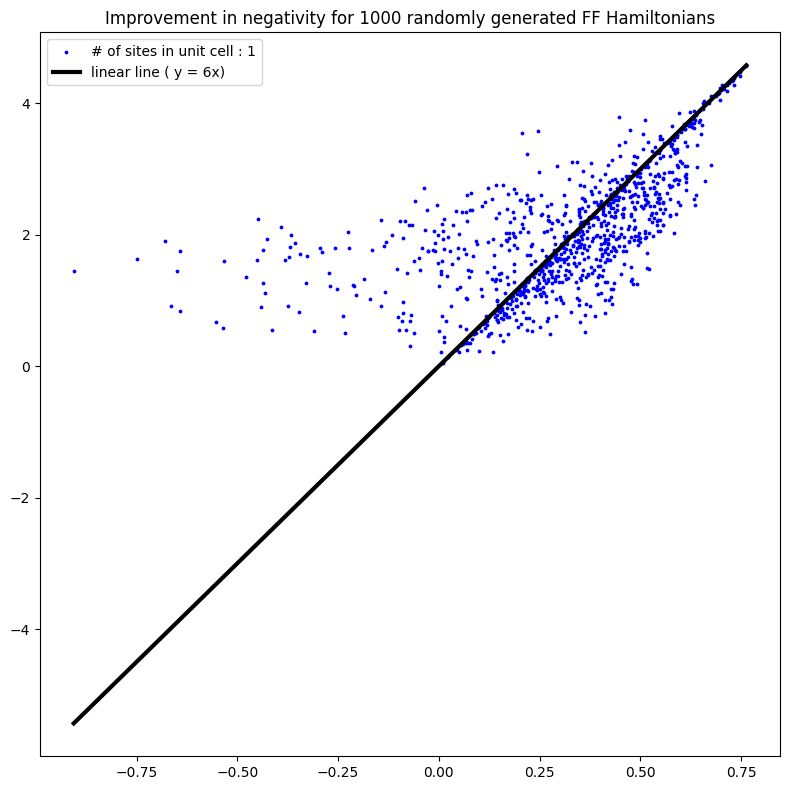

In [10]:
df = pd.DataFrame(res)
# df2 = pd.DataFrame(res2)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(- df['loss_u'] +  df["loss"], - df['neg_ori'] + df['neg_opt'], s = 3, c = "blue", label = "# of sites in unit cell : 1")
# ax.scatter((- df2['loss_u'] + df2["loss"])/2, - df2['neg_ori'] + df2['neg_opt'], s = 3, c = "red", label = "# of sites in unit cell : 2")
min_ = (- df['loss_u'] +  df["loss"]).min()
max_ = (- df['loss_u'] +  df["loss"]).max()
x = np.linspace(min_, max_, 1000)
ax.plot(x, 6*x, label = "linear line ( y = 6x)", linewidth=3, c = "black")
ax.set_title("Improvement in negativity for 1000 randomly generated FF Hamiltonians")
ax.legend()
fig.tight_layout()
plot_filename = pythonPath / f'visualize/image/FF1D/scatter_neg_sps_{3}_bd_{bd}_lt_{1}.pdf'
fig.savefig(plot_filename, dpi=300, format = "pdf")


In [195]:
val = (df2['loss_u'] / df['loss_u'])
(val < 1).sum() / len(val)
loss_u2 = df2['loss_u'].values
loss_u = df['loss_u'].values
# loss_u2[val > 1] = loss_u[val > 1]

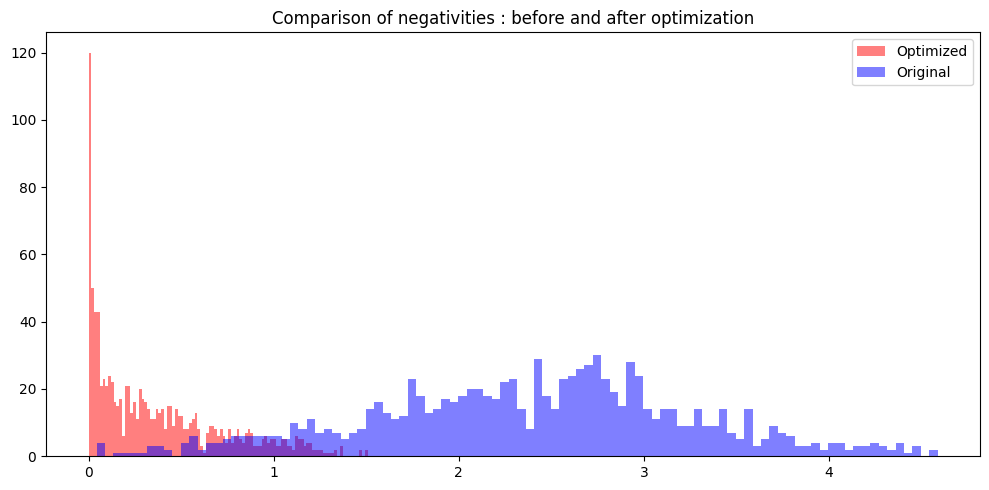

In [43]:
df = pd.DataFrame(res)
# df2 = pd.DataFrame(res2)
# df.loss = df.loss / lt

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(-df['neg_opt'], label = "Optimized", bins = 100, alpha = 0.5, color = "r")
ax.hist(-df['neg_ori'], label = "Original", bins = 100, alpha = 0.5, color = "b")
# ax.hist(-df2['neg_opt'], label = "Optimized", bins = 100, alpha = 0.5, color = "b")
# 
# ax.hist(df2['neg_opt'], label = "# of sites in unit cell : 2", bins = 100)

ax.set_title("Comparison of negativities : before and after optimization")
ax.legend()
fig.tight_layout()
plot_filename = pythonPath / f'visualize/image/FF1D/hist_neg_sps_{3}_bd_{bd}_lt_{1}.pdf'
fig.savefig(plot_filename, dpi=300, format = "pdf")


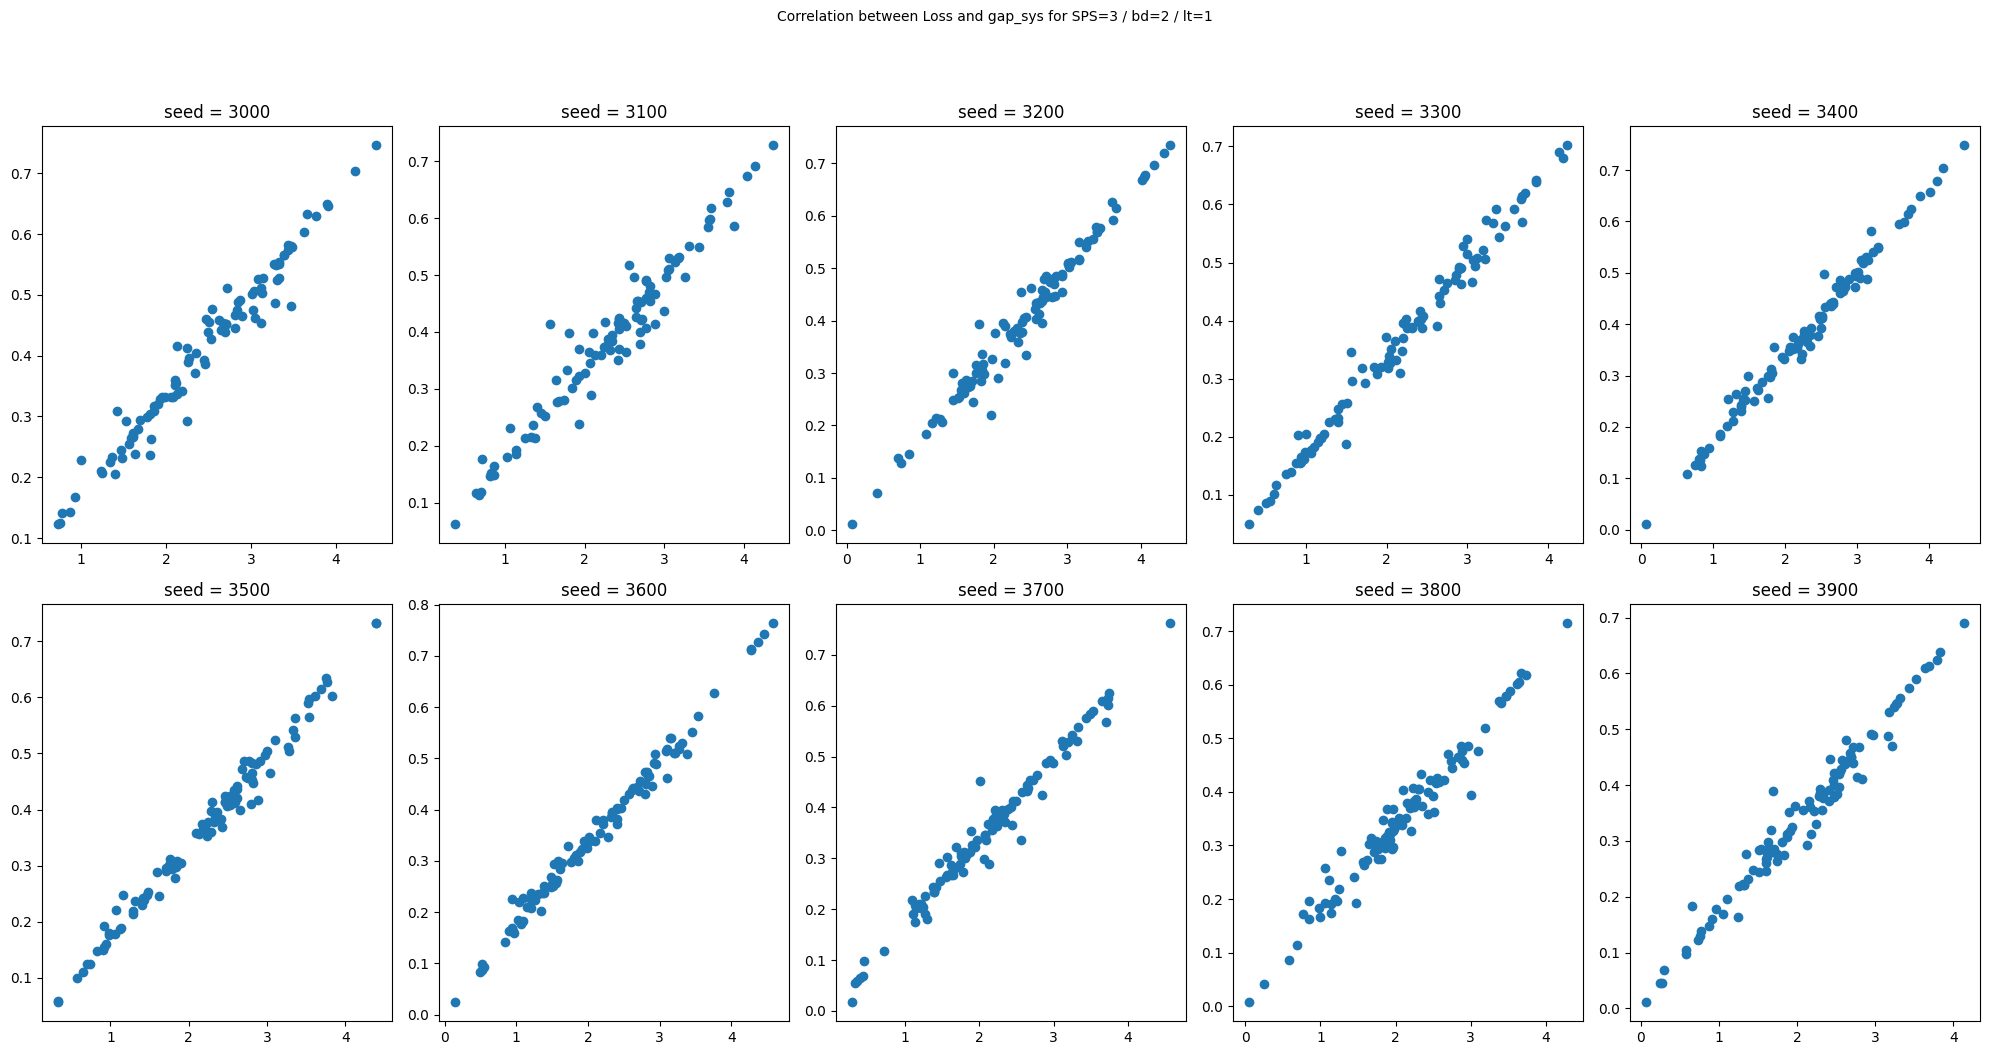

In [65]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))  # Corrected order here
for i in range(10):
    sample_df = df.iloc[i*100:(i+1)*100]
    ax[i//5, i % 5].scatter(-sample_df['neg_ori'] + sample_df['neg_opt'], sample_df['loss'] - sample_df["loss_u"])
    ax[i//5, i % 5].set_title(f"seed = {sample_df['seed'].iloc[0]}")
#     for j in range(len(sample_df)):  # Changed to 'j' to avoid conflict with outer loop
#         ax[i//5, i % 5].annotate(sample_df['seed'].iloc[j],  # Also changed to 'j' here
#                                  (sample_df['log_gap_sys'].iloc[j],
#                                   sample_df['loss'].iloc[j]),
#                                  textcoords="offset points", xytext=(0, 10), ha='center')

fig.suptitle(
    f'Correlation between Loss and gap_sys for SPS={sps} / bd={bd} / lt={lt}', size=10, y=1.05)
fig.tight_layout()
# plot_filename = f'visualize/image/FF1D/scatter_sps_{sps}_bd_{bd}_lt_{lt}.png'
# plt.savefig(plot_filename, dpi=300)


## Compare for different beta at L = 6

In [4]:
df.n_sites.unique()

array([ 29,  11,  73,  21,   8,   6, 100,  15,  54,  39,  42,  87,  69,
        51,  60,  33,  78, 105,  24,  96])

In [49]:
df_dict["mel"]

,model_name,alpha,temperature,n_sites,u_path,ham_path,sweeps,e,e_error,as,as_error,c,c_error,m,m_error,chi,chi_error,seed,loss
481,FF_1D,0.2,0.1000,8,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,4000000,475.306000,361.129000,-0.000166,0.000953,1.734140e+06,1.573670e+06,0.0,0.0,0.0,0.0,0,0.17387
492,FF_1D,0.2,0.2154,8,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,4000000,0.319463,0.020979,0.082990,0.001236,2.194420e-01,1.196280e-01,0.0,0.0,0.0,0.0,0,0.17387
485,FF_1D,0.2,0.4642,8,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,4000000,0.775455,0.002903,0.724603,0.001001,2.948140e-01,3.210640e-03,0.0,0.0,0.0,0.0,0,0.17387
488,FF_1D,0.2,1.0000,8,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,4000000,2.012790,0.003091,0.966527,0.000309,2.309860e-01,8.798630e-04,0.0,0.0,0.0,0.0,0,0.17387


In [45]:
data = np.concatenate([df_dict["mel"]['e'], df_dict["none"]['e']])
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(Q3, Q1)


2.013355 -0.7257452499999999


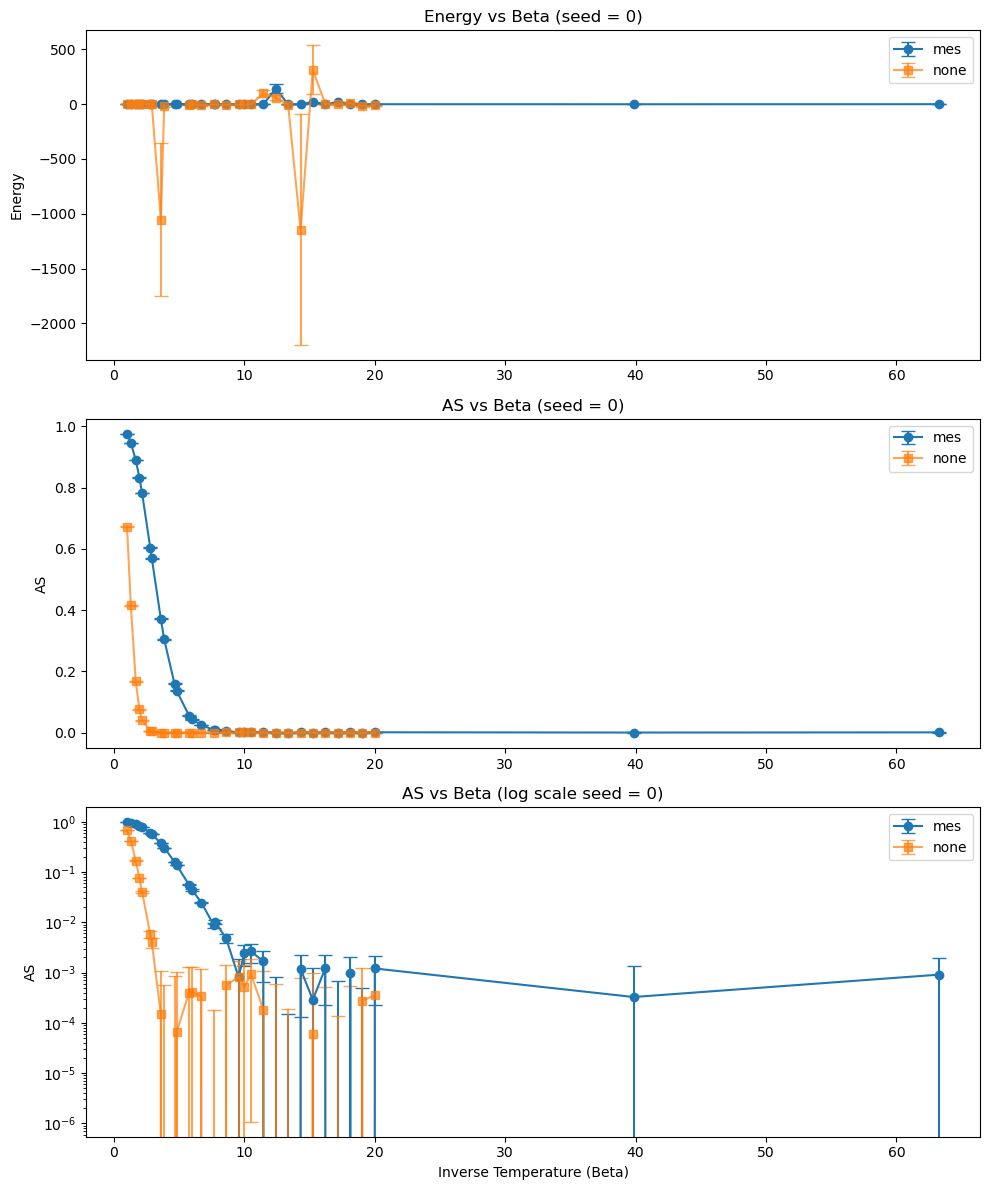

In [5]:
n = 6
df_n = df[df.n_sites == n]
seed_list = sorted(df_n.seed.unique())

for seed in [0]:
    dfs = df_n[df_n.seed == seed]
    df_dict = {}
    df_dict["mel"] = dfs[dfs.u_path.str.contains("mel")]
    df_dict["none"] = dfs[dfs.u_path == ""]

    for key, _df in df_dict.items():
        df_dict[key] = _df.loc[_df.groupby("temperature")["as"].idxmax()].sort_values(by="temperature")

    fig, ax = plt.subplots(3, figsize=(10, 12))
    # gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1], hspace=0.4)
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]

    # Plotting Energy vs Inverse Temperature (Beta) in ax1
    ax1.errorbar(1/df_dict["mel"]['temperature'], df_dict["mel"]['e'], yerr=df_dict["mel"]['e_error'], fmt='o-', capsize=5, label='mes')
    ax1.errorbar(1/df_dict["none"]['temperature'], df_dict["none"]['e'], yerr=df_dict["none"]['e_error'], fmt='s-', capsize=5, label='none', alpha=0.7)
    ax1.set_title(f'Energy vs Beta (seed = {seed})')
    ax1.set_ylabel('Energy')
    ax1.legend()
#     ax1.set_ylim(-0.5, df_dict["mel"].e.iloc[-1]+0.1)

    # Plotting AS vs Inverse Temperature in ax2
    ax2.errorbar(1/df_dict["mel"]['temperature'], df_dict["mel"]['as'], yerr=df_dict["mel"]['as_error'], fmt='o-', capsize=5, label='mes')
    ax2.errorbar(1/df_dict["none"]['temperature'], df_dict["none"]['as'], yerr=df_dict["none"]['as_error'], fmt='s-', capsize=5, label='none', alpha=0.7)
    ax2.set_title(f'AS vs Beta (seed = {seed})')
    ax2.set_ylabel('AS')
    ax2.legend()

    # Plotting AS vs Inverse Temperature (Log Scale) in ax3
    ax3.errorbar(1/df_dict["mel"]['temperature'], df_dict["mel"]['as'], yerr=df_dict["mel"]['as_error'], fmt='o-', capsize=5, label='mes')
    ax3.errorbar(1/df_dict["none"]['temperature'], df_dict["none"]['as'], yerr=df_dict["none"]['as_error'], fmt='s-', capsize=5, label='none', alpha=0.7)
    ax3.set_title(f'AS vs Beta (log scale seed = {seed})')
    ax3.set_xlabel('Inverse Temperature (Beta)')
    ax3.set_ylabel('AS')
    ax3.set_yscale('log')
    ax3.legend()

    fig.tight_layout()
#     fig.show()
    fig.savefig(f"image/n_{n}_seed={seed}_mes_vs_none")
    



## Compare for different beta and different L

In [32]:
dft

,model_name,alpha,temperature,n_sites,u_path,ham_path,sweeps,e,e_error,as,as_error,c,c_error,m,m_error,chi,chi_error,seed,loss
245,FF_1D_L_6,0.2,0.0158,6,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,4000000,-0.802397,0.408123,0.000625,0.000957,163.592,121.109,0.0,0.0,0.0,0.0,0,0.17387
246,FF_1D_L_6,0.2,0.0158,6,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,../python/rmsKit/array/torch/FF1D_loc/s_3_r_2_...,4000000,-0.852408,0.292592,0.000910,0.001027,105.774,176.491,0.0,0.0,0.0,0.0,0,0.17387


number of data is not sufficient
number of data is not sufficient


/Users/keisukemurota/miniconda3/envs/torch21/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


number of data is not sufficient
number of data is not sufficient


/Users/keisukemurota/miniconda3/envs/torch21/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


number of data is not sufficient
number of data is not sufficient


/Users/keisukemurota/miniconda3/envs/torch21/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


number of data is not sufficient
number of data is not sufficient
number of data is not sufficient


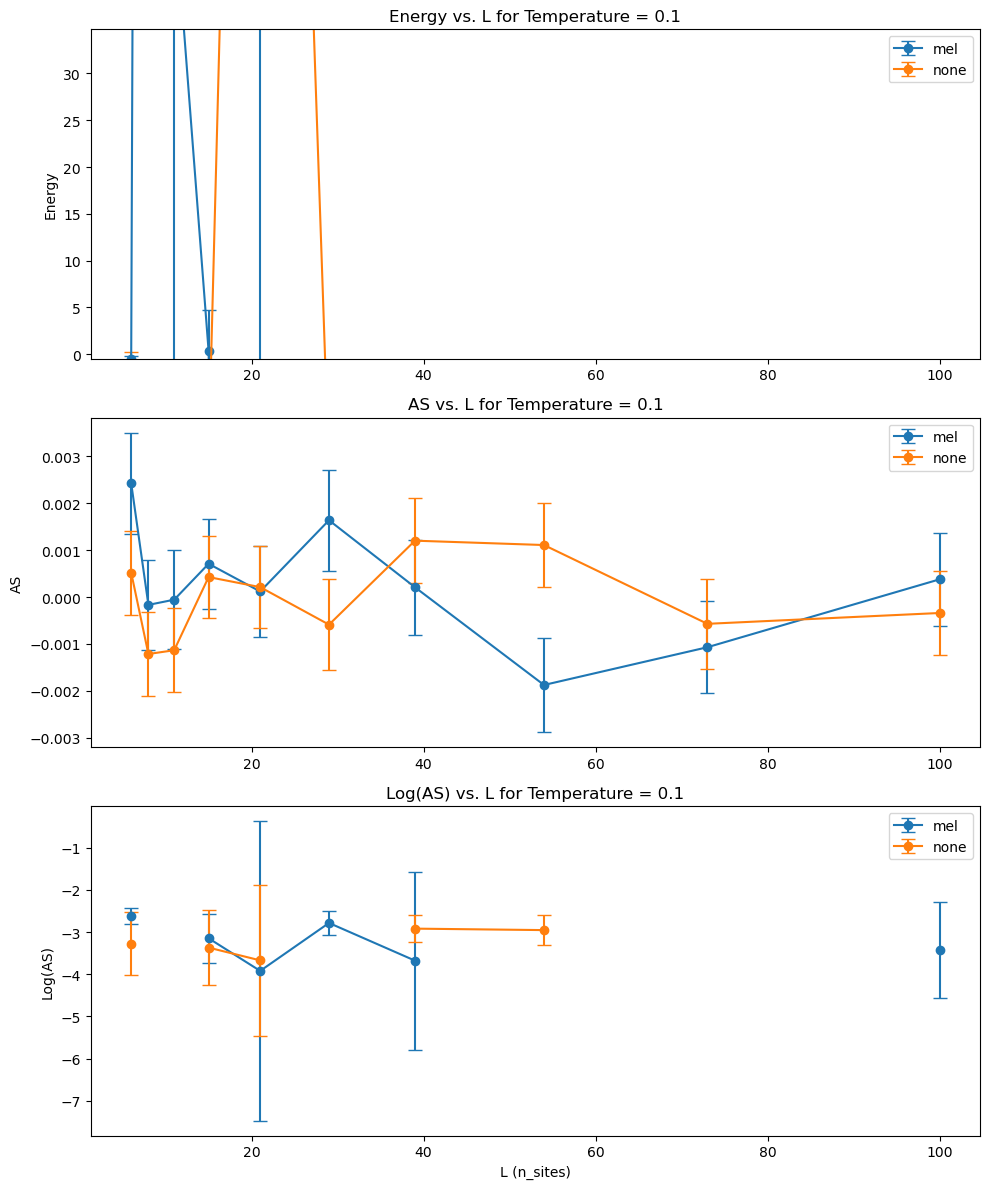

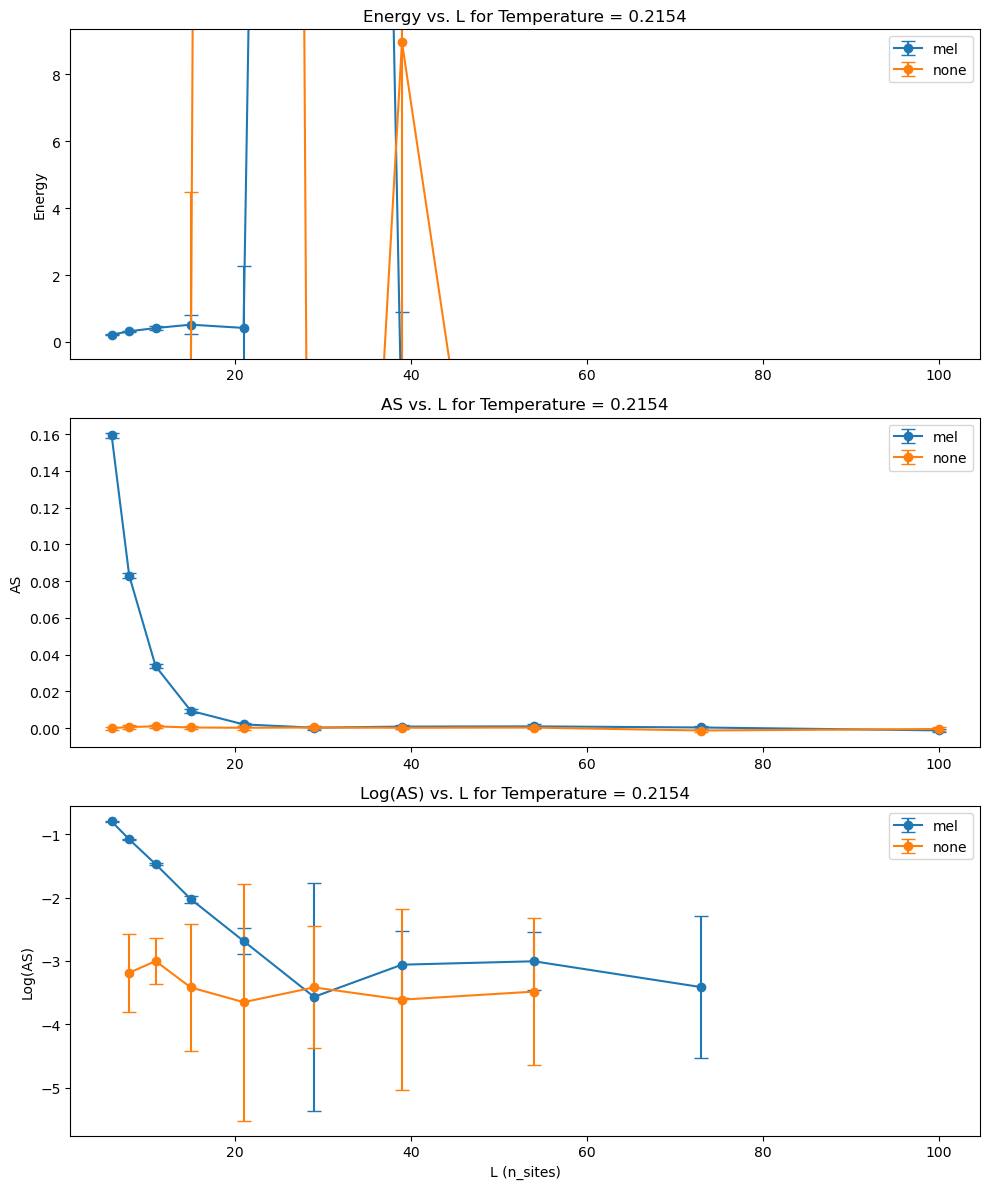

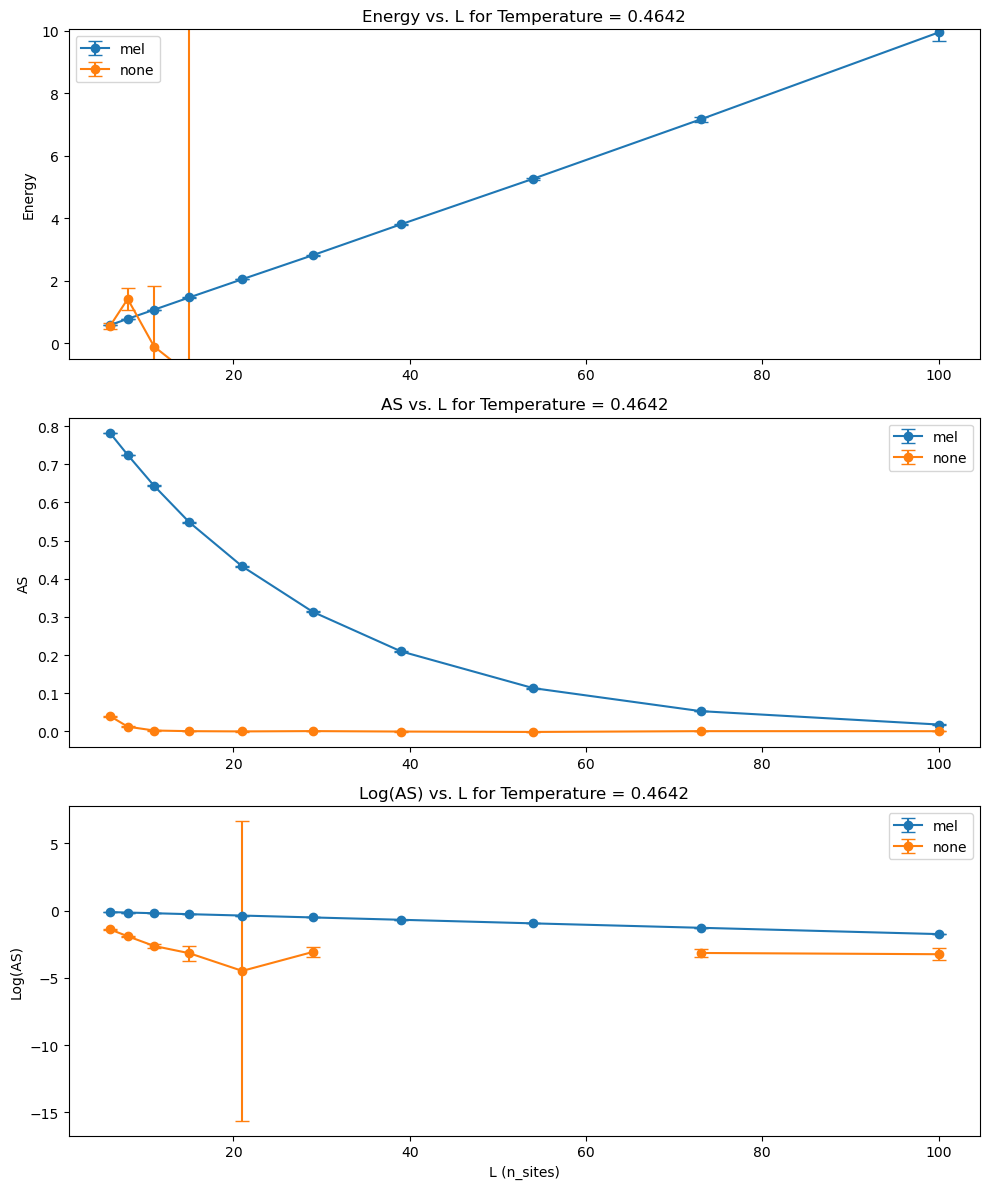

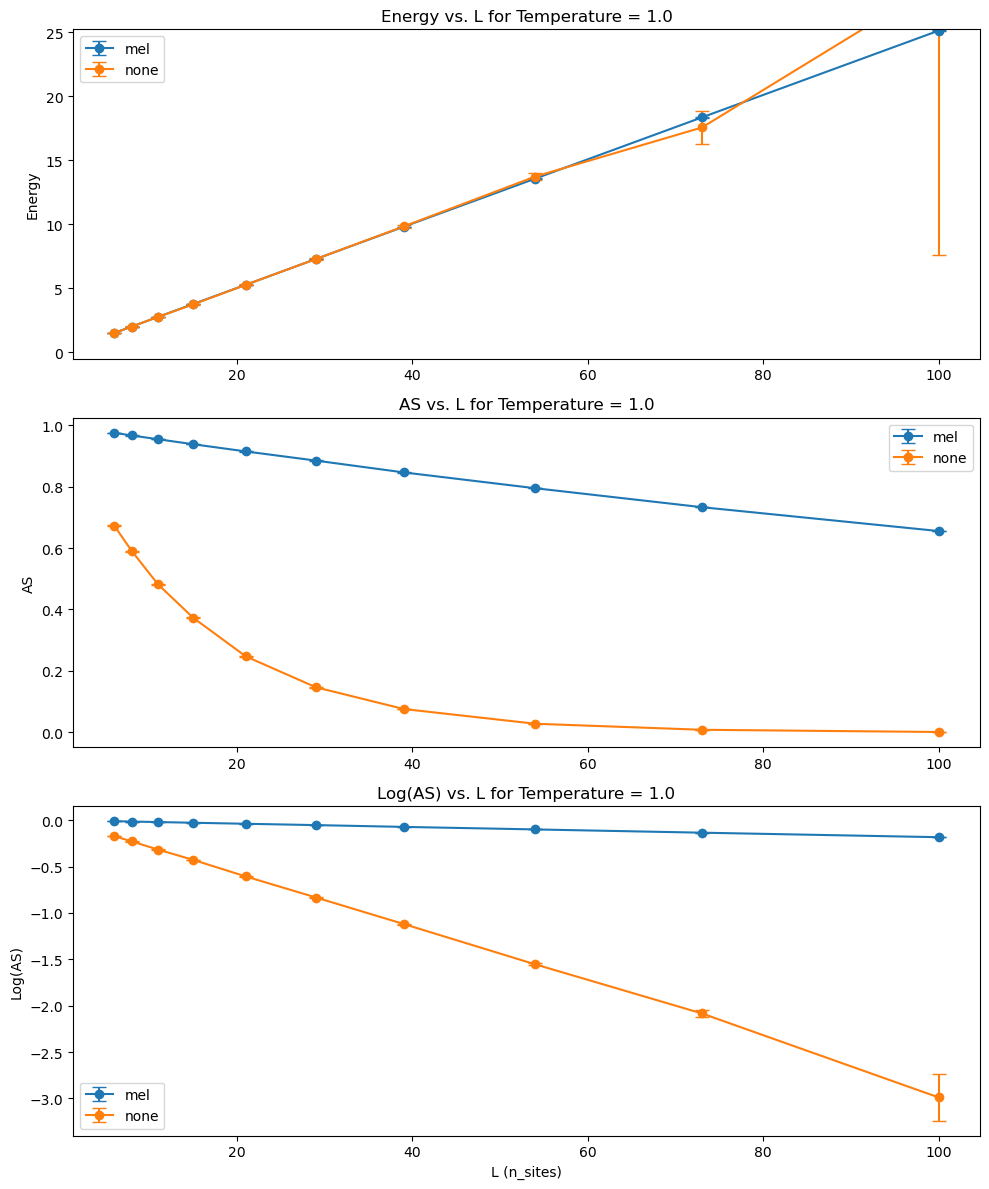

In [23]:
import matplotlib.pyplot as plt
import numpy as np

seed = 0
L_list = sorted(df.n_sites.unique())
dfs = df[df.seed == seed]
t_list = sorted(dfs.temperature.unique())

for t in t_list:
    dft = dfs[dfs.temperature == t]
    df_dict = {}
    df_dict["mel"] = dft[dft.u_path.str.contains("mel")]
    df_dict["none"] = dft[dft.u_path == ""]
    
    if (len(dft) / len(df_dict)) < 2:
        print("number of data is not sufficient")
        continue
    
    for key, _df in df_dict.items():
        df_dict[key] = _df.loc[_df.groupby("n_sites")["as"].idxmax()].sort_values(by="n_sites")

    fig, ax = plt.subplots(3, figsize=(10, 12))
    ax1 = ax[0]
    ax2 = ax[1]
    ax3 = ax[2]

    # 1. Plotting Energy vs L in ax1
    for key, _df in df_dict.items():
        ax1.errorbar(_df["n_sites"], _df["e"], yerr=_df["e_error"], label=key, marker='o', capsize=5)
    ax1.set_title(f'Energy vs. L for Temperature = {t}')
    ax1.set_ylabel('Energy')
#     ax1.set_ylim(-, 3)
    ax1.set_ylim(-0.5, np.abs(df_dict["mel"].e.iloc[-1]+0.1))
    ax1.legend()

    # 2. Plotting AS vs L in ax2
    for key, _df in df_dict.items():
        ax2.errorbar(_df["n_sites"], _df["as"], yerr=_df["as_error"], label=key, marker='o', capsize=5)
    ax2.set_title(f'AS vs. L for Temperature = {t}')
    ax2.set_ylabel('AS')
    ax2.legend()

    # 3. Plotting AS (log) vs L in ax3
    for key, _df in df_dict.items():
        as_log_error = np.abs(_df["as_error"] / (_df["as"] * np.log(10)))
        ax3.errorbar(_df["n_sites"], np.log10(_df["as"]), yerr=as_log_error, label=key, marker='o', capsize=5)
    ax3.set_title(f'Log(AS) vs. L for Temperature = {t}')
    ax3.set_xlabel('L (n_sites)')
    ax3.set_ylabel('Log(AS)')
    ax3.legend()

    fig.tight_layout()
    fig.savefig(f"image/seed={seed}_t={t}_mes_vs_none.png")
